In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import mglearn
%matplotlib inline

### 2.3.4 나이브 베이즈 분류기

+ **GaussianNB, BernoulliNB, MultinomialNB**
  + GaussianNB : 연속적인 데이터
  + BernoulliNB : 이진 데이터
  + MultinomialNB : 카운트 데이터
+ 선형 분류기 보다 훈련속도가 빠른 편이지만, 일반화 성능이 조금 뒤짐

+ BernoulliNB : 특성중 -이 아닌 것이 몇개인지 셈

In [2]:
X = np.array([[0, 1, 0, 1],
              [1, 0 ,1, 1],
              [0, 0, 0, 1],
              [1, 0, 1, 0]])
y = np.array([0, 1, 0, 1])

In [3]:
counts = {}
for label in np.unique(y):
    counts[label] = X[y == label].sum(axis=0)
print('특성 카운트 : \n{}'.format(counts))

특성 카운트 : 
{0: array([0, 1, 0, 2]), 1: array([2, 0, 2, 1])}


+ MultinomialNB : 클래스별로 특성의 평균을 계산
+ GaussianNB: 클래스별로 각 특성의 표준편차와 평균을 저장

#### 장당점과 매개변수 

+ 장단점
  + 훈련과 예측속도가 빠르며 훈련 과정을 이해하기 쉬움
  + 희소한 고차원 데이터에서 잘 작동하며 비교적 매개변수에 민감하지 않음
  + 선형 모델로는 학습시간이 너무 오래 걸리는 매우 큰 데이터셋에는 나이브베이즈 모델을 시도해볼 만함
+ 매개변수
  + alpha : 모든 특성에 양의 값을 가진 가상의 데이터 포인트를 alpha 개수만큼 추가 -> 통계 데이터를 완만하게 만듦 -> 모델의 복잡도 낮아짐 

### 2.3.5 결정 트리

+ 분류와 회귀에 모두 사용됨
+ 결정 트리는 결정에 다다르기 위해 예/아니오 질문을 이어 나가면서 학습함
  + information gain을 통하여 엔트로피를 낮게 만드는 독립 변수와 기준값을 찾음
  + information gain : $ IG[Y,X]=H[Y]−H[Y|X] $ 
  
  
  + $ H[Y] = - \frac{X_1}{X_1 + X_2} log_2 \frac{X_1}{X_1 + X_2} - \frac{X_2}{X_1 + X_2} log_2 \frac{X_2}{X_1 + X_2}$
  
  
  
  + $ H[Y|X] = \frac{1}{2} H[Y|X = X_1] + \frac{1}{2} H[Y|X = X_2] $

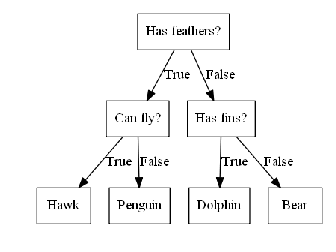

In [4]:
mglearn.plots.plot_animal_tree()

#### 결정트리 만들기

In [5]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)


def plot_decision_regions(X, y, model, title):
    resolution = 0.01
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = mpl.colors.ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    
    plt.contour(xx1, xx2, Z, cmap=mpl.colors.ListedColormap(['k']))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], s=80, label=cl)

    plt.legend(loc='upper left')
    plt.title(title)
    
    return Z

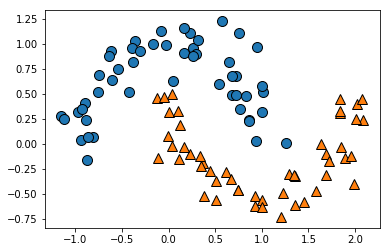

In [6]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, shuffle=True, noise=0.15, random_state=0)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

In [7]:
from sklearn.tree import DecisionTreeClassifier

tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0).fit(X, y)

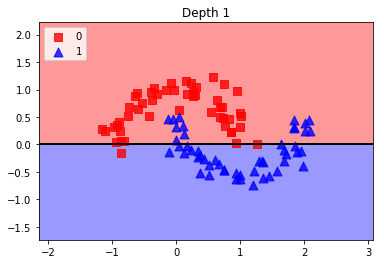

In [8]:
plot_decision_regions(X, y, tree1, "Depth 1")
plt.show()

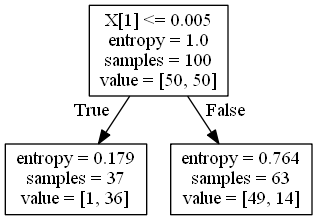

In [9]:
draw_decision_tree(tree1)

#### 결정트리의 복잡도 제어하기

+ 모든 피르 노드가 순수 노드가 될 때까지 진행하면 모델이 매우 복잡해지고 오버피팅이 된다
    + 트리를 일찍 중단하는 사전 가지치기
    + 트리를 만든후 데이터 포인트가 적은 노드를 삭제하거나 병합한느 사후가지치기(가지치기)

+ 유방암 데이터를 이용한 사전 가지치기의 효과 확인
    + 가지치기를 하지 않은 경우 훈련 세트의 정확도는 1이 나오지만 테스트 세트의 정확도는 .94

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train, y_train)
print('훈련 세트 정확도 : {:.3f}'.format(tree.score(X_train, y_train)))
print('테스트 세트 정확도 : {:.3f}'.format(tree.score(X_test, y_test)))

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.944


+ max_dapth 를 4로 제한시킨 결과 테스트 세트의 정확도가 높아짐

In [11]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0).fit(X_train, y_train)
print('훈련 세트 정확도 : {:.3f}'.format(tree.score(X_train, y_train)))
print('테스트 세트 정확도 : {:.3f}'.format(tree.score(X_test, y_test)))

훈련 세트 정확도 : 0.986
테스트 세트 정확도 : 0.958


#### 결정트리의 분석

In [12]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot', class_names=['N', 'T'], 
                feature_names=cancer.feature_names, impurity=False, filled=True)

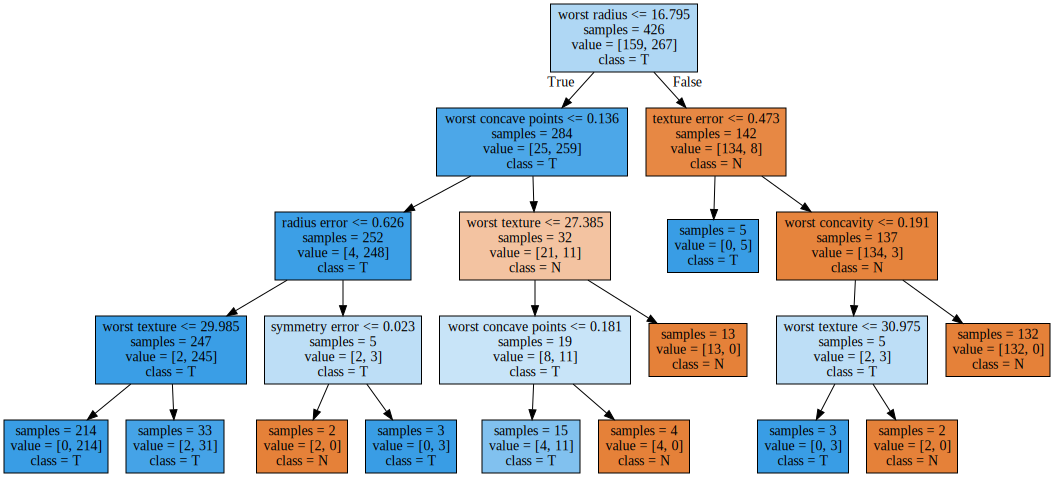

In [13]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### 트리의 특성 중요도 

In [14]:
print('특성 중요도 : \n{}'.format(tree.feature_importances_))

특성 중요도 : 
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.02093242  0.06165377  0.          0.
  0.          0.          0.          0.          0.01268893  0.
  0.62610311  0.05695529  0.          0.          0.          0.          0.0417274
  0.17993908  0.          0.        ]


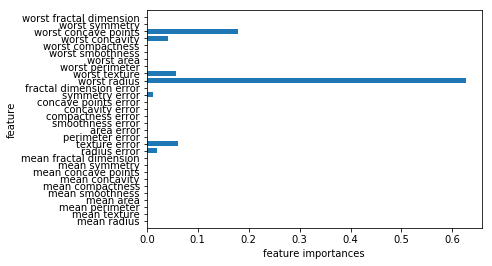

In [15]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel('feature importances')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(tree)

Feature importances: [ 0.  1.]


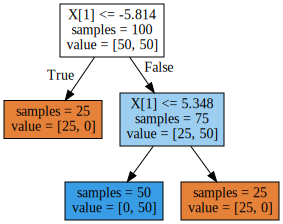

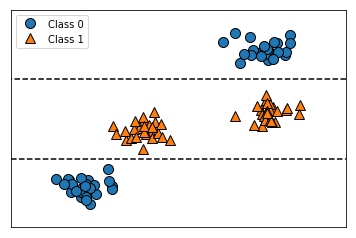

In [16]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

+ 컴퓨터 메모리 가격동향 데이터셋

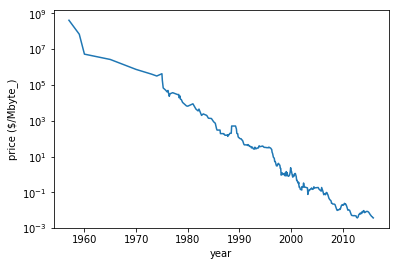

In [17]:
import pandas as pd
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'ram_price.csv'))

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel('year')
plt.ylabel('price ($/Mbyte_)')

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

X_train = data_train.date[:, np.newaxis]
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

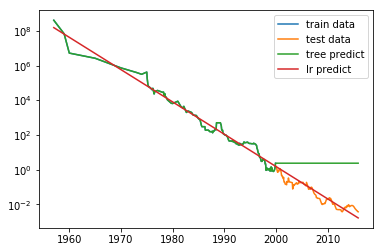

In [19]:
plt.semilogy(data_train.date, data_train.price, label='train data')
plt.semilogy(data_test.date, data_test.price, label='test data')
plt.semilogy(ram_prices.date, price_tree, label='tree predict')
plt.semilogy(ram_prices.date, price_lr, label='lr predict')
plt.legend()

#### 장단점과 매개변수

+ 매개변수 : 사전가지치기의 max_depth, max_leaf_nodes, min_samples_lesf
    
+ 장단점 
  + 장점  
      + 만들어진 모델의 시각화가 쉬워 비전문가도 이해하기 쉬움, 
      + 데이터의 스케일에 구애받지 않음 -> 정규화나 표준화 같은 전처리가 필요없음
      + 특성의 스케일이 서로 다르거나 이진 특성과 연속적인 특성이 혼합되어 있어도 잘 작동함
  + 단점
      + 과대적합 되기 쉬움 -> 일반화 성능은 좋지 않음
      + 훈련 데이터의 범위를 넘긴 데이터는 예측하지 못함

### 2.3.6 결정 트리의 앙상블

+ 앙상블 : 여러 머신러닝 모델을 연결하여 더 강력한 모델을 만드는 기법
    + random forest, gradient boosting

#### random forest
+ 과대적합을 피하기 위한 방법
  + 조금씩 다른 여러 결정 트리의 묶음
    + 트리를 만들떄 사용하는 데이터 포인트를 무작위로 선택하는 방법
    + 분할 테스트에서 특성을 무작위로 선택하는 방법

#### 랜덤 포레스트 구축
1. 생성할 트리의 개수(RandomForestRegression, RandomForestClassifier의 n_estimators 매개변수)
2. 부트스트랩 샘플 생성
  + n_samples 횟수만큼 반복 추출
    + 예를들어 ['a', 'b', 'c', 'd']일 경우 가능한 부트스트랩 샘플은 ['d', 'b', 'b', 'c'], ['d', 'a', 'b', 'a'] 등등
3. 부트스트랩으로 생성된 샘플로 결정트리를 만듬
  + 각 노드에서 전체 특성을 대상으로 최선의 테스트를 찾는 것이 아니고 알고리즘이 각 노드에서 후보 특성을 무작위로 선택한 후 이 후보들 중에서 최선의 테스트를 찾음
  + 랜덤 포레스트가 조금씩 다른 데이터셋을 이용해 만들어 지도록 함
    + 몇개의 특성을 고를지는 max_features 매개변수로 조정
      + max_features = n_feature 인경우 모든특성을 고려하므로  무작위성이 들어가지 않음(부트스트랩 무작위성은 그대로)
      + max_features = 1 인경우 트리의 분기는 테스트할 특성을 고를 필요가 없게 되어 무작위로 선택한 특성의 임계값을 찾기만 함
      + 즉, max_features값을 높게 하면 트리들이 매우 비슷해지고 가장 두드러진 특성을 이용해 데이터에 잘 맞춰짐 max_features가 낮아지면 랜덤 포레스트 트리들은 많이 달라지고 각 트리는 데이터에 맞추기 위해 깊이가 깊어지게 됨


+ 랜덤 포레스트로 예측을 할 때는 먼저 알고리즘이 모델에 있는 모든 트리의 예측을 만듦
+ 회귀의 경우에는 예특들의 평균을 최종예측으로 함
+ 분류의 경우는 투표전략을 사용


#### 랜덤 포레스트 분석

In [20]:
from sklearn.ensemble import RandomForestClassifier

X, y = make_moons(n_samples=100, shuffle=True, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

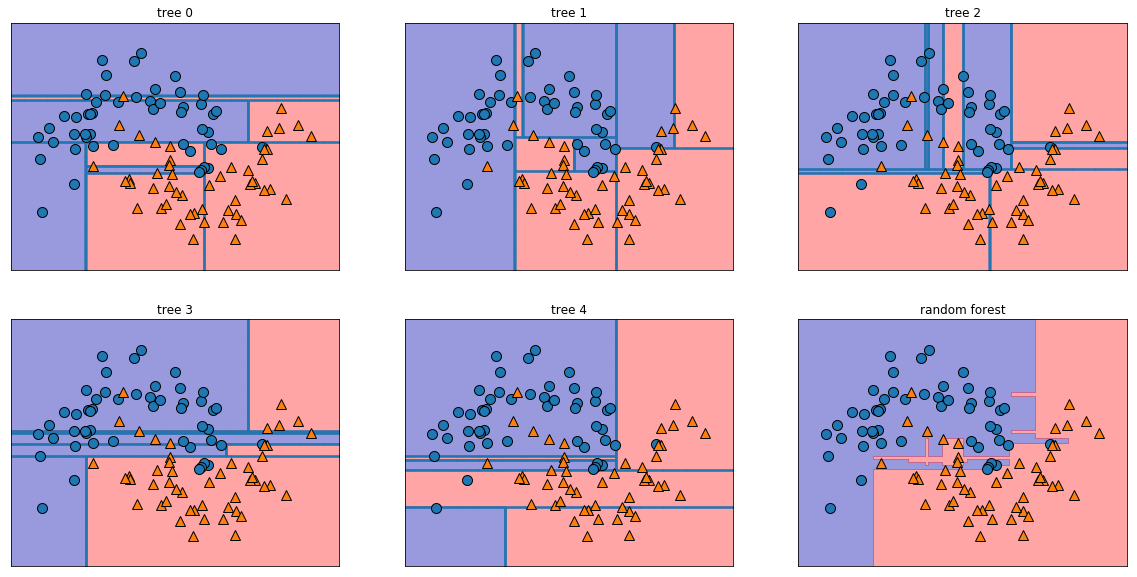

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title('tree {}'.format(i))
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("random forest")
mglearn.discrete_scatter(X[:, 0], X[:, 1],  y)

+ 유방암 데이터셋에 100개의 트리로 이워진 랜덤 포레스트

In [25]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print('훈련 세트 정확도 : {}'.format(forest.score(X_train, y_train)))
print('테스트 세트 정확도 : {}'.format(forest.score(X_test, y_test)))

훈련 세트 정확도 : 1.0
테스트 세트 정확도 : 0.972027972027972


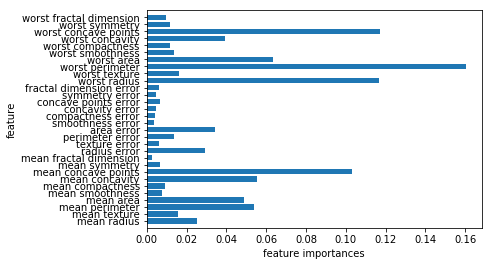

In [28]:
plot_feature_importances_cancer(forest)

#### 장단점과 매개변수

+ 장단점 
  + 랜덤포레스트는 성능이 뛰어나고 매개변수 튜닝을 많이 하지 않아도 잘 작동함
  + 트리의 단점을 보안하고 장점은 그대로 가지고 있음
  + 텍스트 데이터 같이 매우 차원이 높고 희소한 데이터에는 잘 작동하지 않음 -> 선형 모델이 더 적합
  + 병렬화 하여도 선형 모델보다 훈련과 예측이 느림
  
+ 매개변수 
  + n_estimators, max_feature, max_depth : 트리와 동일
  + 멀티 코어 프로세스일 경우 n_jobs를 통해 사용할 코어수를 지정할수 있음
  + random_state를 다르게 지정하면 다른 모델이 나옴(트리가 많을 수록 random_state값에 따른 변동이 적어짐)

#### 그래디언트 부스팅 회귀 트리

+ 여러 개의 결정 트리를 묶어 강력한 모델을 만드는 방법
+ 회귀와 분류 모두 사용 가능
+ 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듦
+ 얕은 트리 같은 간단한 모델을 많이 연결하는 것(트리가 많이 추가될수록 성능이 좋아짐)

+ 유방암 데이터셋을 이용한 그래디언트 부스팅 분류

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print('훈련 세트 정확도 : {}'.format(gbrt.score(X_train, y_train)))
print('테스트 세트 정확도 : {}'.format(gbrt.score(X_test, y_test)))

훈련 세트 정확도 : 1.0
테스트 세트 정확도 : 0.958041958041958


훈련 세트 정확도가 100% 이므로 과대적합 됨   
트리의 깊이를 줄여 사전가지치기를 강하게 하거나 학습률을 낮춤

In [31]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print('훈련 세트 정확도 : {}'.format(gbrt.score(X_train, y_train)))
print('테스트 세트 정확도 : {}'.format(gbrt.score(X_test, y_test)))

훈련 세트 정확도 : 0.9906103286384976
테스트 세트 정확도 : 0.972027972027972


In [32]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=.01)
gbrt.fit(X_train, y_train)

print('훈련 세트 정확도 : {}'.format(gbrt.score(X_train, y_train)))
print('테스트 세트 정확도 : {}'.format(gbrt.score(X_test, y_test)))

훈련 세트 정확도 : 0.9882629107981221
테스트 세트 정확도 : 0.965034965034965


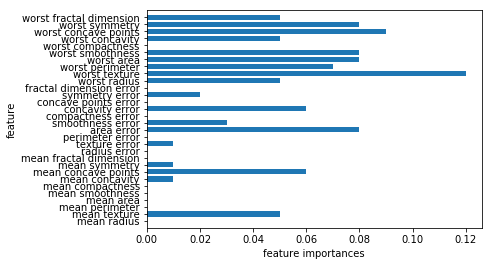

In [33]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

#### 장단점과 매개변수

+ 장단점
  + 텍스트 데이터 같이 매우 차원이 높고 희소한 데이터에는 잘 작동하지 않음 -> 선형 모델이 더 적합
  + 그래디언트 부스팅 결정 트리는 지도 학습에서 가장 강력하고 널리 사용되는 모델중 하나
  + 가장 큰 단점은 매개변수를 잘 조정해야 한다는 것과 훈련 시간이 길다는 것
+ 매개변수
  + n_estimators : 트리의 개수, n_estimators가 크면 모델이 복잡해지고 괴대적합될 가능성이 높아짐
  + learning_rate : 트리의 오차를 보정하는 정도, 학습률을 낮추면 비슷한 복잡도의 모델을 만들기 위해서 더 많은 트리를 차가해야 함
  + 일반적으로 가용한 메모리 한도에서 n_estimators를 낮추고 적정한 learnong_rate를 찾음
  + 통상 그래디언트 부스팅 모델에서는 max_depth를 매우 작게 설정하며 트리의 깊이가 5보다 깊어지지 않음